# Project Setup

## 1. Imports and Data Handling

In [1]:
# Import necessary libraries
import os
import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from google.colab import files
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report

# Set device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Mount Google Drive to save the model
from google.colab import drive
drive.mount('/content/drive')

# Directory in Google Drive to save the trained model
model_save_path = '/content/drive/MyDrive/LLM_drive/'
os.makedirs(model_save_path, exist_ok=True)

# Load the tokenizer and the pre-trained BERT model
print("Loading BERT tokenizer and model...")
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)  # 3 classes: antiracist, neutral, racist
print("Model and tokenizer loaded successfully!")

Mounted at /content/drive
Loading BERT tokenizer and model...


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model and tokenizer loaded successfully!


## 2. Data Loading and Preprocessing

In [2]:
# Paths to saved tokenized data and tokenizer
data_dir = '/content/drive/MyDrive/LLM_drive/data/tokenized_data'
input_ids_path = os.path.join(data_dir, 'input_ids.pt')
attention_masks_path = os.path.join(data_dir, 'attention_masks.pt')
labels_path = os.path.join(data_dir, 'labels.pt')
tokenizer_path = os.path.join(data_dir, 'bert_tokenizer')  # Removed leading slash for subfolder creation

# Debugging prints to check paths
print("Checking paths for tokenized data and tokenizer:")
print(f"input_ids_path: {input_ids_path}")
print(f"attention_masks_path: {attention_masks_path}")
print(f"labels_path: {labels_path}")
print(f"tokenizer_path (directory): {tokenizer_path}")

# Check if tokenized data and tokenizer already exist
if (os.path.exists(input_ids_path) and
    os.path.exists(attention_masks_path) and
    os.path.exists(labels_path) and
    os.path.exists(tokenizer_path)):

    print("Tokenized data and tokenizer found. Loading from disk...")
    input_ids = torch.load(input_ids_path)
    attention_masks = torch.load(attention_masks_path)
    labels = torch.load(labels_path)
    tokenizer = BertTokenizer.from_pretrained(tokenizer_path)
    print("Tokenized data and tokenizer loaded successfully!")

else:
    print("Tokenized data or tokenizer not found. Processing and saving data...")

    # Load the processed data
    print("Loading processed data...")
    anti_df = pd.read_csv('/content/drive/MyDrive/LLM_drive/data/antiracist_data.csv')
    neutral_df = pd.read_csv('/content/drive/MyDrive/LLM_drive/data/neutral_data.csv')
    racist_df = pd.read_csv('/content/drive/MyDrive/LLM_drive/data/racist_data.csv')

    # Combine datasets and create labels
    print("Combining datasets...")
    anti_df['label'] = 0  # Label for antiracist
    neutral_df['label'] = 1  # Label for neutral
    racist_df['label'] = 2  # Label for racist

    df = pd.concat([anti_df, neutral_df, racist_df], ignore_index=True)
    df = df.sample(frac=1).reset_index(drop=True)  # Shuffle the data

    # Initialize the tokenizer
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

    # Tokenization and encoding of the dataset
    def tokenize_data(sentences, tokenizer, max_length=128):
        encoded_inputs = tokenizer(
            sentences,
            return_tensors='pt',
            truncation=True,
            padding=True,
            max_length=max_length
        )
        return encoded_inputs['input_ids'], encoded_inputs['attention_mask']

    print("Tokenizing text data...")
    input_ids, attention_masks = tokenize_data(df['text'].tolist(), tokenizer)

    # Encode the labels
    print("Encoding labels...")
    labels = torch.tensor(df['label'].values)

    # Ensure the directory exists and save the tokenized data and tokenizer for future use
    os.makedirs(data_dir, exist_ok=True)
    torch.save(input_ids, input_ids_path)
    torch.save(attention_masks, attention_masks_path)
    torch.save(labels, labels_path)

    # Ensure tokenizer path directory exists before saving tokenizer
    os.makedirs(tokenizer_path, exist_ok=True)
    tokenizer.save_pretrained(tokenizer_path)

    print("Tokenized data and tokenizer saved successfully!")

Checking paths for tokenized data and tokenizer:
input_ids_path: /content/drive/MyDrive/LLM_drive/data/tokenized_data/input_ids.pt
attention_masks_path: /content/drive/MyDrive/LLM_drive/data/tokenized_data/attention_masks.pt
labels_path: /content/drive/MyDrive/LLM_drive/data/tokenized_data/labels.pt
tokenizer_path (directory): /content/drive/MyDrive/LLM_drive/data/tokenized_data/bert_tokenizer
Tokenized data and tokenizer found. Loading from disk...


<ipython-input-2-dfdc728941ce>:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  input_ids = torch.load(input_ids_path)
<ipython-input-2-dfdc728941ce>:23: FutureWarning: You

Tokenized data and tokenizer loaded successfully!


## 3. Splitting Data and Creating DataLoaders

In [3]:
# Split the data into training and validation sets
print("Splitting data into training and validation sets...")
train_inputs, val_inputs, train_labels, val_labels = train_test_split(input_ids, labels, test_size=0.1)
train_masks, val_masks = train_test_split(attention_masks, test_size=0.1)

# Create DataLoader for training and validation
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_dataloader = DataLoader(train_data, batch_size=16)

val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_dataloader = DataLoader(val_data, batch_size=16)

Splitting data into training and validation sets...


# Base Model

## Loading or Training

In [ ]:
# Define model save path
model_save_dir = '/content/drive/MyDrive/LLM_drive/models/base'
model_save_path = os.path.join(model_save_dir, 'bert_racist_classifier.pth')

# Flag to track if model was newly trained
new_model_trained = False

# Check if model file exists
if os.path.exists(model_save_path):
    print("Model found. Loading the model from Drive...")
    model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)

    # Load model weights and move to device
    model.load_state_dict(torch.load(model_save_path, map_location=device))
    model.to(device)
    print("Model loaded successfully!")

else:
    print("No saved model found. Starting training...")

    # Initialize model and optimizer
    model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)
    model.to(device)
    optimizer = AdamW(model.parameters(), lr=2e-5)
    new_model_trained = True  # Set flag to indicate new training

    # Training loop with progress bar
    epochs = 3
    for epoch in range(epochs):
        print(f"\nEpoch {epoch + 1}/{epochs}")
        model.train()
        total_loss = 0

        # tqdm progress bar for training
        progress_bar = tqdm(train_dataloader, desc="Training", leave=False)

        for step, batch in enumerate(progress_bar):
            # Move batch data to device
            batch_inputs = batch[0].to(device)
            batch_masks = batch[1].to(device)
            batch_labels = batch[2].to(device)

            model.zero_grad()

            outputs = model(input_ids=batch_inputs, attention_mask=batch_masks, labels=batch_labels)
            loss = outputs.loss
            total_loss += loss.item()

            loss.backward()
            optimizer.step()

            # Update progress bar with current loss
            progress_bar.set_postfix(loss=loss.item())

        avg_loss = total_loss / len(train_dataloader)
        print(f"Epoch {epoch + 1} completed. Average Loss: {avg_loss:.4f}")

    # Save the trained model to Google Drive
    os.makedirs(model_save_dir, exist_ok=True)
    torch.save(model.state_dict(), model_save_path)
    print(f"Model saved to {model_save_path}")

## Validation

In [ ]:
# Validation loop with progress bar
print("\nStarting validation...")

model.eval()
val_predictions = []
val_labels_list = []

# tqdm progress bar for validation
progress_bar = tqdm(val_dataloader, desc="Validation", leave=False)

with torch.no_grad():
    for batch in progress_bar:
        batch_inputs = batch[0].to(device)
        batch_masks = batch[1].to(device)
        batch_labels = batch[2].to(device)

        outputs = model(input_ids=batch_inputs, attention_mask=batch_masks)
        logits = outputs.logits

        predictions = torch.argmax(logits, dim=1).cpu().numpy()
        val_predictions.extend(predictions)
        val_labels_list.extend(batch_labels.cpu().numpy())

# Specify target names for the classification report
target_names = ['antiracist', 'neutral', 'racist']

# Calculate accuracy and classification report
accuracy = accuracy_score(val_labels_list, val_predictions)
report = classification_report(val_labels_list, val_predictions, target_names=target_names)

print(f"\nValidation Accuracy: {accuracy:.4f}")
print(f"\nClassification Report:\n{report}")

# Save the validation results
results_save_path = os.path.join('/content/drive/MyDrive//LLM_drive/results/base/', 'validation_report.txt')

# Save the validation results
with open(results_save_path, 'w') as f:
    f.write(f"Validation Accuracy: {accuracy:.4f}\n")
    f.write(f"Classification Report:\n{report}\n")
print(f"Validation results saved to {results_save_path}")

## Tests

In [ ]:
# Load pre-trained model and tokenizer
model_path = '/content/drive/MyDrive/LLM_drive/models/base/bert_racist_classifier.pth'  # Your model path
tokenizer_path = '/content/drive/MyDrive//LLM_drive/data/tokenized_data/bert_tokenizer'  # Your tokenizer path
tokenizer = BertTokenizer.from_pretrained(tokenizer_path)

# Load the pre-trained model and move it to the GPU (if available)
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)
model.load_state_dict(torch.load(model_path))
model.to(device)  # Move the model to GPU or CPU
model.eval()

# Function to get the saliency map for a text input, and print prediction and confidence
def generate_saliency_map(text, model, tokenizer):
    # Tokenize the input text
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True).to(device)
    input_ids = inputs['input_ids']
    attention_mask = inputs['attention_mask']

    # Forward pass to get embeddings
    embeddings = model.bert.embeddings(input_ids)  # Get the input embeddings

    # Ensure gradients are enabled for the embeddings
    embeddings.retain_grad()

    # Forward pass
    outputs = model(inputs_embeds=embeddings, attention_mask=attention_mask)
    logits = outputs.logits

    # Apply softmax to get probabilities
    probabilities = torch.softmax(logits, dim=-1)

    # Get the predicted class and confidence score
    predicted_class = logits.argmax(dim=-1).item()
    confidence_score = probabilities.max().item()

    # Map predicted class to label name (adjust this based on your class labels)
    label_mapping = {0: "Anti-Racist", 1: "Neutral", 2: "Racist"}
    predicted_label = label_mapping[predicted_class]

    # Print prediction and confidence score
    print(f"Predicted Label: {predicted_label}")
    print(f"Confidence Score: {confidence_score:.4f}")

    # Backward pass: Compute gradients with respect to the predicted class
    model.zero_grad()  # Clear any previous gradients
    logits[:, predicted_class].backward()

    # Extract the gradients of the input embeddings
    gradients = embeddings.grad  # Gradients with respect to input tokens

    # Compute the L2 norm of the gradients for each token (to get the saliency)
    saliency = gradients.abs().sum(dim=-1).squeeze().cpu().numpy()

    # Convert input IDs back to tokens for visualization
    tokens = tokenizer.convert_ids_to_tokens(input_ids.squeeze().tolist())

    # Visualize the saliency map
    visualize_saliency(tokens, saliency)

# Function to visualize the saliency map
def visualize_saliency(tokens, saliency):
    # Normalize saliency values for better visualization
    saliency = (saliency - saliency.min()) / (saliency.max() - saliency.min() + 1e-10)

    # Plot the saliency values for each token
    plt.figure(figsize=(12, 6))
    plt.barh(range(len(tokens)), saliency, align='center', color="skyblue")
    plt.yticks(range(len(tokens)), tokens)
    plt.xlabel('Saliency (Gradient Norm)')
    plt.title('Saliency Map for Input Tokens')
    plt.gca().invert_yaxis()  # Display tokens in the correct order (top-to-bottom)
    plt.show()

# Load the test datasets
anti_test_df = pd.read_csv('/content/drive/MyDrive/LLM_drive/data/anti_test.csv')
neutral_test_df = pd.read_csv('/content/drive/MyDrive/LLM_drive/data/neutral_test.csv')
racist_test_df = pd.read_csv('/content/drive/MyDrive/LLM_drive/data/racist_test.csv')

# neutral_test_df = pd.read_csv('Data/processed/neutral_test.csv')
# racist_test_df = pd.read_csv('Data/processed/racist_test.csv')
# anti_test_df = pd.read_csv('Data/processed/anti_test.csv')

# Assign labels to each dataset
neutral_test_df['label'] = 1  # Label for neutral class
racist_test_df['label'] = 2   # Label for racist class
anti_test_df['label'] = 0     # Label for anti-racist class

# Add a column to indicate the source dataset
neutral_test_df['dataset'] = 'Neutral'
racist_test_df['dataset'] = 'Racist'
anti_test_df['dataset'] = 'Anti-Racist'

# Combine the dataframes after adding labels
combined_test_df = pd.concat([neutral_test_df, racist_test_df, anti_test_df])

# Select a random row from the combined dataset
random_row = combined_test_df.sample(n=1).iloc[0]

# Print the full row to show the source and type
print("\nSelected Entry from Dataset:")
print(random_row)

# Extract the text from the selected row
random_text = random_row['text']
print(f"\nRandom Text: {random_text}")

# Generate and display the saliency map for the random input
generate_saliency_map(random_text, model, tokenizer)

# Deep Ensamble

## 1. Define Paths and Parameters

In [9]:
# Define paths and parameters
num_ensemble_models = 5
ensemble_model_save_dir = '/content/drive/MyDrive/LLM_drive/models/deep_ensembles'
os.makedirs(ensemble_model_save_dir, exist_ok=True)

# Initialize the tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

## 2. Function to Load or Train Ensemble Models

In [10]:
# Function to load each model if it exists, otherwise train a new one
def load_or_train_ensemble_model(i, train_dataloader, epochs=3):
    model_path = os.path.join(ensemble_model_save_dir, f'bert_ensemble_model_{i+1}.pth')
    if os.path.exists(model_path):
        print(f"Model {i+1} found. Loading from Drive...")
        model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)
        model.load_state_dict(torch.load(model_path, map_location=device))
        model.to(device)
        print(f"Model {i+1} loaded successfully!")
    else:
        print(f"No saved model found for model {i+1}. Starting training...")
        model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)
        model.to(device)
        optimizer = AdamW(model.parameters(), lr=2e-5)

        # Training loop
        for epoch in range(epochs):
            print(f"\nEpoch {epoch + 1}/{epochs} for model {i+1}")
            model.train()
            total_loss = 0
            for step, batch in enumerate(tqdm(train_dataloader, desc="Training", leave=False)):
                batch_inputs, batch_masks, batch_labels = (b.to(device) for b in batch)
                model.zero_grad()
                outputs = model(input_ids=batch_inputs, attention_mask=batch_masks, labels=batch_labels)
                loss = outputs.loss
                total_loss += loss.item()
                loss.backward()
                optimizer.step()

            avg_loss = total_loss / len(train_dataloader)
            print(f"Epoch {epoch + 1} for model {i+1} completed. Average Loss: {avg_loss:.4f}")

        # Save the trained model
        torch.save(model.state_dict(), model_path)
        print(f"Model {i+1} saved to {model_path}")

    return model

## 3. Load or Train Ensemble Models

In [11]:
# Print the directory being used for model loading/saving
print(f"Looking for saved models in: {ensemble_model_save_dir}")
print(f"Available files in this directory: {os.listdir(ensemble_model_save_dir)}")

# Load or train all models for the ensemble
ensemble_models = [load_or_train_ensemble_model(i, train_dataloader) for i in range(num_ensemble_models)]

Looking for saved models in: /content/drive/MyDrive/LLM_drive/models/deep_ensembles
Available files in this directory: ['bert_ensemble_model_1.pth', 'bert_ensemble_model_2.pth', 'bert_ensemble_model_3.pth', 'bert_ensemble_model_4.pth', 'bert_ensemble_model_5.pth']
Model 1 found. Loading from Drive...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-10-dc9d578c85f4>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We reco

Model 1 loaded successfully!
Model 2 found. Loading from Drive...
Model 2 loaded successfully!
Model 3 found. Loading from Drive...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model 3 loaded successfully!
Model 4 found. Loading from Drive...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model 4 loaded successfully!
Model 5 found. Loading from Drive...
Model 5 loaded successfully!


## 4. Ensemble Prediction and Uncertainty Estimation Function

In [12]:
# Function for ensemble predictions and uncertainty estimation
def ensemble_predict(ensemble_models, dataloader):
    all_model_predictions = []

    # Total number of iterations for the entire ensemble (num_models * num_batches)
    total_batches = len(ensemble_models) * len(dataloader)

    with tqdm(total=total_batches, desc="Ensemble Prediction", leave=False) as pbar:
        for model_idx, model in enumerate(ensemble_models):
            model_predictions = []
            model.eval()

            with torch.no_grad():
                for batch_idx, batch in enumerate(dataloader):
                    batch_inputs = batch[0].to(device)
                    batch_masks = batch[1].to(device)

                    outputs = model(input_ids=batch_inputs, attention_mask=batch_masks)
                    logits = outputs.logits

                    predictions = torch.argmax(logits, dim=1).cpu().numpy()
                    model_predictions.extend(predictions)

                    # Update progress bar with model and batch index
                    pbar.set_postfix(model=f"{model_idx + 1}/{len(ensemble_models)}", batch=batch_idx + 1)
                    pbar.update(1)  # Update progress by one batch

            # Convert model predictions to a numpy array and add to list
            all_model_predictions.append(np.array(model_predictions))

    # Stack predictions from all models (shape: [num_models, num_samples])
    all_model_predictions = np.stack(all_model_predictions)

    # Calculate final predictions by majority vote (mode)
    final_predictions = np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=0, arr=all_model_predictions)

    # Calculate uncertainty as the variance of the predictions
    uncertainties = np.var(all_model_predictions, axis=0)

    return final_predictions, uncertainties

## 5. Run Ensemble Predictions on Validation Set

In [13]:
# Run ensemble predictions on the validation set
ensemble_predictions, ensemble_uncertainties = ensemble_predict(ensemble_models, val_dataloader)

# Extract true labels from val_dataloader
val_labels_list = []
for batch in val_dataloader:
    _, _, labels = batch
    val_labels_list.extend(labels.cpu().numpy())  # Accumulate labels for each batch

# Define target names for classification report
target_names = ['antiracist', 'neutral', 'racist']

# Calculate accuracy and report for the ensemble
accuracy = accuracy_score(val_labels_list, ensemble_predictions)
report = classification_report(val_labels_list, ensemble_predictions, target_names=target_names)

print(f"\nEnsemble Validation Accuracy: {accuracy:.4f}")
print(f"\nEnsemble Classification Report:\n{report}")

# Display uncertainties for each prediction
print(f"Uncertainty for each prediction (as variance):\n{ensemble_uncertainties}")


Ensemble Validation Accuracy: 0.8632

Ensemble Classification Report:
              precision    recall  f1-score   support

  antiracist       0.85      0.76      0.80      8508
     neutral       0.85      0.89      0.87     15517
      racist       0.89      0.91      0.90     10569

    accuracy                           0.86     34594
   macro avg       0.86      0.85      0.86     34594
weighted avg       0.86      0.86      0.86     34594

Uncertainty for each prediction (as variance):
[0.   0.   0.16 ... 0.   0.   0.24]


## 6. Save Ensemble Validation Results

In [14]:
# Save the ensemble validation results
results_save_path = os.path.join(ensemble_model_save_dir, 'ensemble_validation_report.txt')
with open(results_save_path, 'w') as f:
    f.write(f"Ensemble Validation Accuracy: {accuracy:.4f}\n")
    f.write(f"Ensemble Classification Report:\n{report}\n")
    f.write(f"Uncertainty for each prediction (as variance):\n{ensemble_uncertainties}\n")
print(f"Ensemble validation results saved to {results_save_path}")

Ensemble validation results saved to /content/drive/MyDrive/LLM_drive/models/deep_ensembles/ensemble_validation_report.txt


# Prompt Engineering

## Prompt Definition

In [6]:
# Define prompts including a "no prompt" option
prompts = [
    "Is this text antiracist, neutral, or racist?",
    "Classify the following text for potential bias: ",
    "Identify the sentiment as antiracist, neutral, or racist for the following text: ",
    ""  # No prompt (baseline)
]

## Data Preparation with Prompts

In [7]:
# Implement prompt engineering by prepending prompts to the input texts
print("Starting prompt engineering...")

# Initialize a list to store validation accuracies and reports for each prompt
prompt_results = []

for prompt_id, prompt in enumerate(prompts):
    print(f"\nProcessing data with prompt ID {prompt_id}: '{prompt}'")

    # Define paths to save the tokenized data for this prompt
    data_dir = f'/content/drive/MyDrive/LLM_drive/data/tokenized_data/prompt_{prompt_id}'
    input_ids_path = os.path.join(data_dir, 'input_ids.pt')
    attention_masks_path = os.path.join(data_dir, 'attention_masks.pt')
    labels_path = os.path.join(data_dir, 'labels.pt')
    tokenizer_path = os.path.join(data_dir, 'bert_tokenizer')

    # Check if tokenized data and tokenizer for this prompt already exist
    if (os.path.exists(input_ids_path) and
        os.path.exists(attention_masks_path) and
        os.path.exists(labels_path) and
        os.path.exists(tokenizer_path)):

        print("Tokenized data and tokenizer found. Loading from disk...")
        input_ids = torch.load(input_ids_path)
        attention_masks = torch.load(attention_masks_path)
        labels = torch.load(labels_path)
        tokenizer = BertTokenizer.from_pretrained(tokenizer_path)
        print("Tokenized data and tokenizer loaded successfully!")

    else:
        print("Tokenized data or tokenizer not found. Processing and saving data...")

        # Load the processed data
        print("Loading processed data...")
        anti_df = pd.read_csv('/content/drive/MyDrive/LLM_drive/data/antiracist_data.csv')
        neutral_df = pd.read_csv('/content/drive/MyDrive/LLM_drive/data/neutral_data.csv')
        racist_df = pd.read_csv('/content/drive/MyDrive/LLM_drive/data/racist_data.csv')

        # Combine datasets and create labels
        print("Combining datasets...")
        anti_df['label'] = 0  # Label for antiracist
        neutral_df['label'] = 1  # Label for neutral
        racist_df['label'] = 2  # Label for racist

        df = pd.concat([anti_df, neutral_df, racist_df], ignore_index=True)
        df = df.sample(frac=1).reset_index(drop=True)  # Shuffle the data

        # Prepend the prompt to each text
        print("Prepending prompt to texts...")
        if prompt != "":
            df['text'] = prompt + " " + df['text']

        # Initialize the tokenizer
        tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

        # Tokenization and encoding of the dataset
        def tokenize_data(sentences, tokenizer, max_length=128):
            encoded_inputs = tokenizer(
                sentences,
                return_tensors='pt',
                truncation=True,
                padding=True,
                max_length=max_length
            )
            return encoded_inputs['input_ids'], encoded_inputs['attention_mask']

        print("Tokenizing text data...")
        input_ids, attention_masks = tokenize_data(df['text'].tolist(), tokenizer)

        # Encode the labels
        print("Encoding labels...")
        labels = torch.tensor(df['label'].values)

        # Ensure the directory exists and save the tokenized data and tokenizer for future use
        os.makedirs(data_dir, exist_ok=True)
        torch.save(input_ids, input_ids_path)
        torch.save(attention_masks, attention_masks_path)
        torch.save(labels, labels_path)

        # Save the tokenizer
        tokenizer.save_pretrained(tokenizer_path)

        print("Tokenized data and tokenizer saved successfully!")

    # Split the data into training and validation sets
    print("Splitting data into training and validation sets...")
    train_inputs, val_inputs, train_labels, val_labels = train_test_split(input_ids, labels, test_size=0.1)
    train_masks, val_masks = train_test_split(attention_masks, test_size=0.1)

    # Create DataLoader for training and validation
    train_data = TensorDataset(train_inputs, train_masks, train_labels)
    train_dataloader = DataLoader(train_data, batch_size=16)

    val_data = TensorDataset(val_inputs, val_masks, val_labels)
    val_dataloader = DataLoader(val_data, batch_size=16)

    # Define model save path for this prompt
    model_save_dir = f'/content/drive/MyDrive/LLM_drive/models/prompt_{prompt_id}'
    model_save_path = os.path.join(model_save_dir, 'bert_racist_classifier.pth')

    # Check if model file exists
    if os.path.exists(model_save_path):
        print("Model found. Loading the model from Drive...")
        model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)

        # Load model weights and move to device
        model.load_state_dict(torch.load(model_save_path, map_location=device))
        model.to(device)
        print("Model loaded successfully!")

    else:
        print("No saved model found. Starting training...")

        # Initialize model and optimizer
        model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)
        model.to(device)
        optimizer = AdamW(model.parameters(), lr=2e-5)

        # Training loop with progress bar
        epochs = 3
        for epoch in range(epochs):
            print(f"\nEpoch {epoch + 1}/{epochs} for prompt '{prompt}'")
            model.train()
            total_loss = 0

            # tqdm progress bar for training
            progress_bar = tqdm(train_dataloader, desc="Training", leave=False)

            for step, batch in enumerate(progress_bar):
                # Move batch data to device
                batch_inputs = batch[0].to(device)
                batch_masks = batch[1].to(device)
                batch_labels = batch[2].to(device)

                model.zero_grad()

                outputs = model(input_ids=batch_inputs, attention_mask=batch_masks, labels=batch_labels)
                loss = outputs.loss
                total_loss += loss.item()

                loss.backward()
                optimizer.step()

                # Update progress bar with current loss
                progress_bar.set_postfix(loss=loss.item())

            avg_loss = total_loss / len(train_dataloader)
            print(f"Epoch {epoch + 1} completed. Average Loss: {avg_loss:.4f}")

        # Save the trained model to Google Drive
        os.makedirs(model_save_dir, exist_ok=True)
        torch.save(model.state_dict(), model_save_path)
        print(f"Model saved to {model_save_path}")

    # Validation loop with progress bar
    print(f"\nStarting validation for prompt '{prompt}'...")

    model.eval()
    val_predictions = []
    val_labels_list = []

    # tqdm progress bar for validation
    progress_bar = tqdm(val_dataloader, desc="Validation", leave=False)

    with torch.no_grad():
        for batch in progress_bar:
            batch_inputs = batch[0].to(device)
            batch_masks = batch[1].to(device)
            batch_labels = batch[2].to(device)

            outputs = model(input_ids=batch_inputs, attention_mask=batch_masks)
            logits = outputs.logits

            predictions = torch.argmax(logits, dim=1).cpu().numpy()
            val_predictions.extend(predictions)
            val_labels_list.extend(batch_labels.cpu().numpy())

    # Specify target names for the classification report
    target_names = ['antiracist', 'neutral', 'racist']

    # Calculate accuracy and classification report
    accuracy = accuracy_score(val_labels_list, val_predictions)
    report = classification_report(val_labels_list, val_predictions, target_names=target_names)

    print(f"\nValidation Accuracy for prompt '{prompt}': {accuracy:.4f}")
    print(f"\nClassification Report:\n{report}")

    # Save the validation results
    results_save_dir = f'/content/drive/MyDrive/LLM_drive/results/prompt_{prompt_id}'
    results_save_path = os.path.join(results_save_dir, 'validation_report.txt')
    os.makedirs(results_save_dir, exist_ok=True)

    with open(results_save_path, 'w') as f:
        f.write(f"Validation Accuracy: {accuracy:.4f}\n")
        f.write(f"Classification Report:\n{report}\n")
    print(f"Validation results saved to {results_save_path}")

    # Append the results to the list
    prompt_results.append({
        'prompt_id': prompt_id,
        'prompt': prompt,
        'accuracy': accuracy,
        'classification_report': report
    })

Starting prompt engineering...

Processing data with prompt ID 0: 'Is this text antiracist, neutral, or racist?'
Tokenized data or tokenizer not found. Processing and saving data...
Loading processed data...
Combining datasets...
Prepending prompt to texts...


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Tokenizing text data...
Encoding labels...
Tokenized data and tokenizer saved successfully!
Splitting data into training and validation sets...
No saved model found. Starting training...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(



Epoch 1/3 for prompt 'Is this text antiracist, neutral, or racist?'


Epoch 1 completed. Average Loss: 0.5665

Epoch 2/3 for prompt 'Is this text antiracist, neutral, or racist?'


Epoch 2 completed. Average Loss: 0.4291

Epoch 3/3 for prompt 'Is this text antiracist, neutral, or racist?'


Epoch 3 completed. Average Loss: 0.3121
Model saved to /content/drive/MyDrive/LLM_drive/models/prompt_0/bert_racist_classifier.pth

Starting validation for prompt 'Is this text antiracist, neutral, or racist?'...



Validation Accuracy for prompt 'Is this text antiracist, neutral, or racist?': 0.7669

Classification Report:
              precision    recall  f1-score   support

  antiracist       0.72      0.61      0.66      8463
     neutral       0.78      0.79      0.78     15572
      racist       0.79      0.86      0.82     10559

    accuracy                           0.77     34594
   macro avg       0.76      0.75      0.75     34594
weighted avg       0.76      0.77      0.76     34594

Validation results saved to /content/drive/MyDrive/LLM_drive/results/prompt_0/validation_report.txt

Processing data with prompt ID 1: 'Classify the following text for potential bias: '
Tokenized data or tokenizer not found. Processing and saving data...
Loading processed data...
Combining datasets...
Prepending prompt to texts...


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Tokenizing text data...
Encoding labels...
Tokenized data and tokenizer saved successfully!
Splitting data into training and validation sets...
No saved model found. Starting training...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(



Epoch 1/3 for prompt 'Classify the following text for potential bias: '


Epoch 1 completed. Average Loss: 0.5708

Epoch 2/3 for prompt 'Classify the following text for potential bias: '


Epoch 2 completed. Average Loss: 0.4352

Epoch 3/3 for prompt 'Classify the following text for potential bias: '


Epoch 3 completed. Average Loss: 0.3219
Model saved to /content/drive/MyDrive/LLM_drive/models/prompt_1/bert_racist_classifier.pth

Starting validation for prompt 'Classify the following text for potential bias: '...



Validation Accuracy for prompt 'Classify the following text for potential bias: ': 0.7719

Classification Report:
              precision    recall  f1-score   support

  antiracist       0.74      0.56      0.64      8376
     neutral       0.75      0.84      0.79     15583
      racist       0.82      0.84      0.83     10635

    accuracy                           0.77     34594
   macro avg       0.77      0.75      0.75     34594
weighted avg       0.77      0.77      0.77     34594

Validation results saved to /content/drive/MyDrive/LLM_drive/results/prompt_1/validation_report.txt

Processing data with prompt ID 2: 'Identify the sentiment as antiracist, neutral, or racist for the following text: '
Tokenized data or tokenizer not found. Processing and saving data...
Loading processed data...
Combining datasets...
Prepending prompt to texts...


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Tokenizing text data...
Encoding labels...
Tokenized data and tokenizer saved successfully!
Splitting data into training and validation sets...
No saved model found. Starting training...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(



Epoch 1/3 for prompt 'Identify the sentiment as antiracist, neutral, or racist for the following text: '


Epoch 1 completed. Average Loss: 0.5699

Epoch 2/3 for prompt 'Identify the sentiment as antiracist, neutral, or racist for the following text: '


Epoch 2 completed. Average Loss: 0.4292

Epoch 3/3 for prompt 'Identify the sentiment as antiracist, neutral, or racist for the following text: '


Epoch 3 completed. Average Loss: 0.3054
Model saved to /content/drive/MyDrive/LLM_drive/models/prompt_2/bert_racist_classifier.pth

Starting validation for prompt 'Identify the sentiment as antiracist, neutral, or racist for the following text: '...



Validation Accuracy for prompt 'Identify the sentiment as antiracist, neutral, or racist for the following text: ': 0.7649

Classification Report:
              precision    recall  f1-score   support

  antiracist       0.66      0.70      0.68      8548
     neutral       0.79      0.76      0.77     15540
      racist       0.83      0.83      0.83     10506

    accuracy                           0.76     34594
   macro avg       0.76      0.76      0.76     34594
weighted avg       0.77      0.76      0.77     34594

Validation results saved to /content/drive/MyDrive/LLM_drive/results/prompt_2/validation_report.txt

Processing data with prompt ID 3: ''
Tokenized data or tokenizer not found. Processing and saving data...
Loading processed data...
Combining datasets...
Prepending prompt to texts...


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Tokenizing text data...
Encoding labels...
Tokenized data and tokenizer saved successfully!
Splitting data into training and validation sets...
No saved model found. Starting training...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(



Epoch 1/3 for prompt ''


Epoch 1 completed. Average Loss: 0.5758

Epoch 2/3 for prompt ''


Epoch 2 completed. Average Loss: 0.4376

Epoch 3/3 for prompt ''


Epoch 3 completed. Average Loss: 0.3255
Model saved to /content/drive/MyDrive/LLM_drive/models/prompt_3/bert_racist_classifier.pth

Starting validation for prompt ''...



Validation Accuracy for prompt '': 0.7754

Classification Report:
              precision    recall  f1-score   support

  antiracist       0.72      0.63      0.67      8419
     neutral       0.76      0.83      0.79     15537
      racist       0.84      0.81      0.83     10638

    accuracy                           0.78     34594
   macro avg       0.77      0.76      0.76     34594
weighted avg       0.77      0.78      0.77     34594

Validation results saved to /content/drive/MyDrive/LLM_drive/results/prompt_3/validation_report.txt


## Comparing Prompt Impacts

### Summarizing Results Across Prompts

In [8]:
# After processing all prompts, display the results
print("\nSummary of Validation Accuracies for Each Prompt:")
for result in prompt_results:
    print(f"Prompt ID: {result['prompt_id']}, Accuracy: {result['accuracy']:.4f}, Prompt: '{result['prompt']}'")


Summary of Validation Accuracies for Each Prompt:
Prompt ID: 0, Accuracy: 0.7669, Prompt: 'Is this text antiracist, neutral, or racist?'
Prompt ID: 1, Accuracy: 0.7719, Prompt: 'Classify the following text for potential bias: '
Prompt ID: 2, Accuracy: 0.7649, Prompt: 'Identify the sentiment as antiracist, neutral, or racist for the following text: '
Prompt ID: 3, Accuracy: 0.7754, Prompt: ''


### Visualization of Prompt Impacts

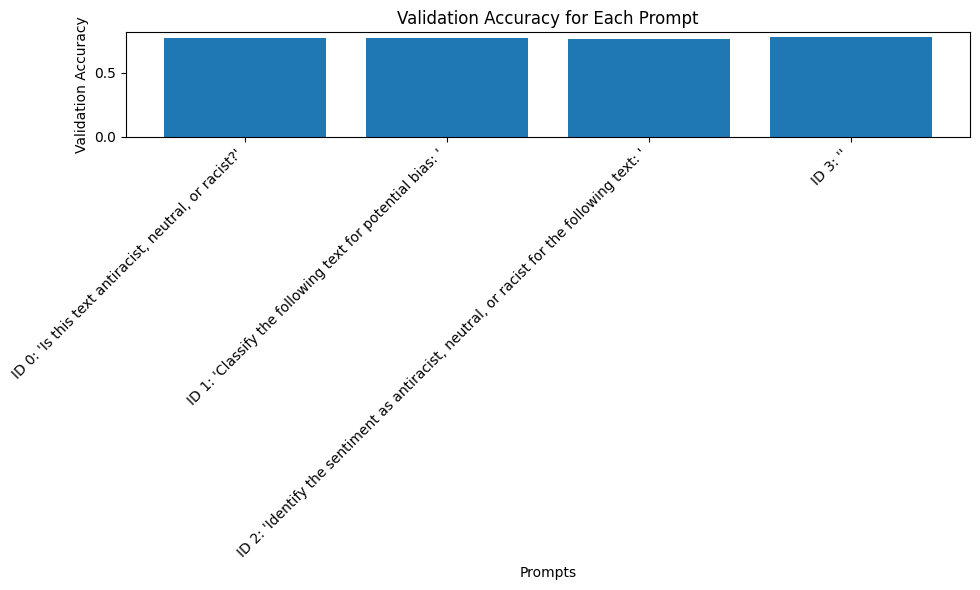

In [9]:
# Visualize the accuracies for each prompt
prompt_ids = [result['prompt_id'] for result in prompt_results]
accuracies = [result['accuracy'] for result in prompt_results]
prompts_text = [f"ID {result['prompt_id']}: '{result['prompt']}'" for result in prompt_results]

plt.figure(figsize=(10, 6))
plt.bar(prompt_ids, accuracies, tick_label=prompts_text)
plt.xticks(rotation=45, ha='right')
plt.xlabel('Prompts')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy for Each Prompt')
plt.tight_layout()
plt.show()

## Testing with Prompts

In [10]:
# Testing the models trained with prompts
for result in prompt_results:
    prompt_id = result['prompt_id']
    prompt = result['prompt']
    print(f"\nTesting model with Prompt ID {prompt_id}: '{prompt}'")

    # Load the tokenizer and model for this prompt
    tokenizer_path = f'/content/drive/MyDrive/LLM_drive/data/tokenized_data/prompt_{prompt_id}/bert_tokenizer'
    tokenizer = BertTokenizer.from_pretrained(tokenizer_path)

    model_path = f'/content/drive/MyDrive/LLM_drive/models/prompt_{prompt_id}/bert_racist_classifier.pth'
    model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()

    # Select a random sample from the combined test dataset
    random_row = combined_test_df.sample(n=1).iloc[0]
    random_text = random_row['text']

    # Prepend the prompt to the text (if not empty)
    if prompt != "":
        test_text = prompt + " " + random_text
    else:
        test_text = random_text

    print(f"\nTest Text: {test_text}")

    # Generate and display the saliency map for the test input
    generate_saliency_map(test_text, model, tokenizer)


Testing model with Prompt ID 0: 'Is this text antiracist, neutral, or racist?'


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-10-cce91041a089>:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We rec

NameError: name 'combined_test_df' is not defined